## 1. Import Required Libraries

In [1]:
import os
import sys
import subprocess
import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
from IPython.display import display, Image

# Set visualization style
sns.set_theme(style="whitegrid")
plt.rcParams['figure.figsize'] = (12, 6)

print("✓ All libraries imported successfully")
print(f"Current working directory: {os.getcwd()}")

✓ All libraries imported successfully
Current working directory: /home/hpc/iwi5/iwi5389h/ExAI-Timeseries-Thesis/nordbyen_heat_benchmark/notebooks


## 2. Configure Benchmark Parameters

**NEW**: Benchmarker will automatically use optimized hyperparameters from HPO Stage 2 (calibrated quantiles) if available.

## 2a. Check HPO Parameters (Stage 2 - Calibrated Quantiles)

Verify that Stage 2 calibrated quantiles are available. Stage 2 includes optimized architecture from Stage 1 + calibrated quantiles for 80% PICP target.

In [2]:
# Check if HPO Stage 2 parameters exist
nhits_hpo = "../results/best_params_NHITS_Q.json"
timesnet_hpo = "../results/best_params_TIMESNET_Q.json"

print("="*70)
print("HPO STAGE 2 PARAMETERS (Architecture + Calibrated Quantiles)")
print("="*70)

if os.path.exists(nhits_hpo):
    with open(nhits_hpo, 'r') as f:
        nhits_data = json.load(f)
    
    is_stage2 = nhits_data.get('stage') == 2
    stage_label = "Stage 2 (Calibrated)" if is_stage2 else "Stage 1 (Architecture Only)"
    
    print(f"\n✓ NHITS_Q HPO parameters found: {stage_label}")
    if is_stage2:
        print(f"  Target PICP: {nhits_data.get('target_picp', 'N/A')}%")
        print(f"  Achieved PICP: {nhits_data.get('achieved_picp', 'N/A')}%")
        print(f"  Calibrated Quantiles: {nhits_data.get('calibrated_quantiles', 'N/A')}")
    print(f"  Stage 1 MAE: {nhits_data.get('stage1_mae', nhits_data.get('best_mae', 'N/A')):.6f}")
    print(f"  Trials: {nhits_data['n_trials']}")
    print(f"  Date: {nhits_data['timestamp']}")
    print(f"  Architecture params:")
    arch_params = nhits_data.get('architecture_params', nhits_data.get('best_params', {}))
    for key, val in arch_params.items():
        print(f"    {key}: {val}")
else:
    print(f"\n⚠️  NHITS_Q: Using default parameters (no HPO results)")

if os.path.exists(timesnet_hpo):
    with open(timesnet_hpo, 'r') as f:
        timesnet_data = json.load(f)
    
    is_stage2 = timesnet_data.get('stage') == 2
    stage_label = "Stage 2 (Calibrated)" if is_stage2 else "Stage 1 (Architecture Only)"
    
    print(f"\n✓ TIMESNET_Q HPO parameters found: {stage_label}")
    if is_stage2:
        print(f"  Target PICP: {timesnet_data.get('target_picp', 'N/A')}%")
        print(f"  Achieved PICP: {timesnet_data.get('achieved_picp', 'N/A')}%")
        print(f"  Calibrated Quantiles: {timesnet_data.get('calibrated_quantiles', 'N/A')}")
    print("  Stage 1 MAE: {timesnet_data.get('stage1_mae', timesnet_data.get('best_mae', 'N/A')):.6f}")
    # print(f"  Trials: {timesnet_data['n_trials']}")
    print(f"  Date: {timesnet_data['timestamp']}")
    print(f"  Architecture params:")
    arch_params = timesnet_data.get('architecture_params', timesnet_data.get('best_params', {}))
    for key, val in arch_params.items():
        print(f"    {key}: {val}")
else:
    print(f"\n⚠️  TIMESNET_Q: Using default parameters (no HPO results)")

print("\n" + "="*70)
print("💡 Benchmarker will use Stage 2 calibrated quantiles for NHITS_Q/TIMESNET_Q")
print("💡 NHITS_MSE/TIMESNET_MSE will use default parameters (no HPO)")
print("="*70)

HPO STAGE 2 PARAMETERS (Architecture + Calibrated Quantiles)

✓ NHITS_Q HPO parameters found: Stage 2 (Calibrated)
  Target PICP: 80.0%
  Achieved PICP: N/A%
  Calibrated Quantiles: [0.1, 0.5, 0.9]
  Stage 1 MAE: 0.026382
  Trials: 20
  Date: 2025-12-29 21:00:00
  Architecture params:
    num_stacks: 5
    num_blocks: 2
    num_layers: 1
    layer_widths: 256
    lr: 5.416887321890497e-05
    dropout: 0.0040207982433668205
    weight_decay: 0.0003017515595635882

✓ TIMESNET_Q HPO parameters found: Stage 2 (Calibrated)
  Target PICP: 80.0%
  Achieved PICP: N/A%
  Calibrated Quantiles: [0.1, 0.5, 0.9]
  Stage 1 MAE: {timesnet_data.get('stage1_mae', timesnet_data.get('best_mae', 'N/A')):.6f}
  Date: 2025-12-30 14:30:00
  Architecture params:
    hidden_size: 64
    conv_hidden_size: 64
    top_k: 5
    lr: 0.0001
    dropout: 0.1

💡 Benchmarker will use Stage 2 calibrated quantiles for NHITS_Q/TIMESNET_Q
💡 NHITS_MSE/TIMESNET_MSE will use default parameters (no HPO)


In [3]:
# Data and results paths (relative to project root)
DATA_PATH = "../../processing/nordbyen_processing/nordbyen_features_engineered.csv"
RESULTS_DIR = "../results"
SCRIPTS_DIR = "../scripts"

# ========================================
# MODELS TO BENCHMARK - Choose strategy:
# ========================================
# Option 1: All models in one job (may take 15-20 hours)
# MODELS_TO_RUN = ["NHITS_Q", "NHITS_MSE", "TIMESNET_Q", "TIMESNET_MSE"]

# # Option 2: Split by architecture (RECOMMENDED - run both jobs in parallel)
# # Job 1: NHITS models (~5-10 hours)
# MODELS_TO_RUN = ["NHITS_Q", "NHITS_MSE"]

# Job 2: TimesNet models (~5-10 hours) - Change to this and run cell 3 again
# MODELS_TO_RUN = ["TIMESNET_Q", "TIMESNET_MSE"]

MODELS_TO_RUN = ["TIMESNET_Q", "NHITS_Q"]

# SLURM job configuration
SLURM_SCRIPT = "../scripts/benchmark_job.slurm"
JOB_ID_FILE = "../scripts/current_job_id.txt"

# Verify data file exists
if os.path.exists(DATA_PATH):
    print(f"✓ Data file found: {DATA_PATH}")
    df_info = pd.read_csv(DATA_PATH, nrows=5)
    print(f"  Columns: {list(df_info.columns[:5])}... (total: {len(df_info.columns)})")
    print(f"  Target: heat_consumption")
else:
    print(f"✗ Data file not found: {DATA_PATH}")
    
# Create results directory if needed
os.makedirs(RESULTS_DIR, exist_ok=True)
print(f"✓ Results directory ready: {RESULTS_DIR}")
print(f"✓ Benchmarking models: {', '.join(MODELS_TO_RUN)}")
print(f"\n💡 Strategy: Split submission - run NHITS, then change line and run TimesNet")

✓ Data file found: ../../processing/nordbyen_processing/nordbyen_features_engineered.csv
  Columns: ['timestamp', 'heat_consumption', 'temp', 'dew_point', 'humidity']... (total: 27)
  Target: heat_consumption
✓ Results directory ready: ../results
✓ Benchmarking models: TIMESNET_Q, NHITS_Q

💡 Strategy: Split submission - run NHITS, then change line and run TimesNet


## 3. Submit SLURM Benchmark Job

**RECOMMENDED**: Submit to SLURM for full benchmarking on GPU

In [36]:
# Submit benchmarker to SLURM
print("Submitting heat benchmarker job to SLURM...")
print(f"Models to run: {', '.join(MODELS_TO_RUN)}")
print(f"Script: {SLURM_SCRIPT}")

# Convert models list to space-separated string for shell argument
models_arg = " ".join(MODELS_TO_RUN)

result = subprocess.run(
    ["sbatch", SLURM_SCRIPT, models_arg],
    capture_output=True,
    text=True,
    cwd="../scripts"
)

if result.returncode == 0:
    # Extract job ID from output: "Submitted batch job 123456"
    job_id = result.stdout.strip().split()[-1]
    print(f"\n✓ Job submitted successfully!")
    print(f"  Job ID: {job_id}")
    print(f"  Models: {', '.join(MODELS_TO_RUN)}")
    print(f"  Log files: {SCRIPTS_DIR}/benchmark_{job_id}.log / benchmark_{job_id}.err")
    print(f"\n💡 Next: Run cell below to monitor job status")
    
    # Save job ID for monitoring
    with open(JOB_ID_FILE, "w") as f:
        f.write(job_id)
else:
    print(f"✗ Error submitting job:\n{result.stderr}")

Submitting heat benchmarker job to SLURM...
Models to run: TIMESNET_Q, NHITS_Q
Script: ../scripts/benchmark_job.slurm

✓ Job submitted successfully!
  Job ID: 1476437
  Models: TIMESNET_Q, NHITS_Q
  Log files: ../scripts/benchmark_1476437.log / benchmark_1476437.err

💡 Next: Run cell below to monitor job status


## 4. Monitor Job Status

Check if the benchmarker job is running or complete.

In [5]:
# Check SLURM job status
if os.path.exists(JOB_ID_FILE):
    with open(JOB_ID_FILE, "r") as f:
        job_id = f.read().strip()
else:
    print("❌ No job ID found. Run cell above to submit the job.")
    job_id = None

if job_id:
    print(f"Checking status of Job {job_id}...")
    print("="*70)
    
    # Check with squeue
    result = subprocess.run(
        ["squeue", "-j", job_id, "--format=%.18i %.9P %.20j %.8u %.8T %.10M %.9l %.6D %R"],
        capture_output=True,
        text=True
    )
    
    if "Invalid job id" in result.stderr or not result.stdout.strip().split('\n')[1:]:
        print(f"⏹️  Job {job_id} is no longer in queue (completed or failed)")
        
        # Check if results exist
        results_file = os.path.join(RESULTS_DIR, "benchmark_results.csv")
        if os.path.exists(results_file):
            print(f"\n✅ Job completed successfully!")
            print(f"   Results file found: {results_file}")
            print(f"\n💡 Next: Continue to next cell to view results")
        else:
            print(f"\n❌ Job completed but results not found!")
            print(f"   Check log files: {SCRIPTS_DIR}/benchmark_{job_id}.log")
    else:
        print(result.stdout)
        print(f"\n⏳ Job is still running. Re-run this cell to check again.")
        print(f"   Estimated time: ~2-3 hours for all 4 models")
        
    # Show recent log output
    log_file = f"{SCRIPTS_DIR}/benchmark_{job_id}.log"
    if os.path.exists(log_file):
        print(f"\n📄 Recent log output (last 15 lines):")
        print("-"*70)
        result = subprocess.run(["tail", "-n", "15", log_file], capture_output=True, text=True)
        print(result.stdout)

Checking status of Job 1477048...
             JOBID PARTITION                 NAME     USER    STATE       TIME TIME_LIMI  NODES NODELIST(REASON)
           1477048      a100 benchmark_all_varian iwi5389h  PENDING       0:00  20:00:00      1 (Priority)


⏳ Job is still running. Re-run this cell to check again.
   Estimated time: ~2-3 hours for all 4 models


## 5. Display Benchmark Results

Load and display the comprehensive metrics comparison.

In [5]:
# Load and display results
results_file = os.path.join(RESULTS_DIR, "benchmark_results.csv")

if not os.path.exists(results_file):
    print("❌ ERROR: Benchmark results not found!")
    print(f"   Expected file: {results_file}")
    print("\n💡 Solution:")
    print("   - Check cell above to see if job is still running")
    print("   - If job completed, check log files for errors")
else:
    results_df = pd.read_csv(results_file)
    
    print("\n📊 HEAT CONSUMPTION BENCHMARK RESULTS")
    print("="*70)
    display(results_df)
    
    # Highlight best performer for each metric
    print("\n🏆 Best Performer by Metric:")
    for metric in ['MAE', 'RMSE', 'MAPE', 'MIW', 'CRPS']:
        if metric in results_df.columns:
            best_model = results_df.loc[results_df[metric].idxmin(), 'Model']
            best_value = results_df[metric].min()
            print(f"  {metric:8s}: {best_model:12s} ({best_value:.4f})")
    
    # For PICP, closer to 80% is better
    if 'PICP' in results_df.columns:
        target_picp = 80.0
        results_df['PICP_diff'] = (results_df['PICP'] - target_picp).abs()
        best_model = results_df.loc[results_df['PICP_diff'].idxmin(), 'Model']
        best_value = results_df.loc[results_df['PICP_diff'].idxmin(), 'PICP']
        print(f"  PICP    : {best_model:12s} ({best_value:.2f}% - closest to 80%)")


📊 HEAT CONSUMPTION BENCHMARK RESULTS


,MAE,RMSE,MAPE,PICP,MIW,CRPS,Model
0,0.211931,0.273440,6.490924,0.000000,0.000000,0.211930,TIMESNET_Q
1,0.221560,0.283149,6.633277,46.416667,0.338843,0.243311,NHITS_Q



🏆 Best Performer by Metric:
  MAE     : TIMESNET_Q   (0.2119)
  RMSE    : TIMESNET_Q   (0.2734)
  MAPE    : TIMESNET_Q   (6.4909)
  MIW     : TIMESNET_Q   (0.0000)
  CRPS    : TIMESNET_Q   (0.2119)
  PICP    : NHITS_Q      (46.42% - closest to 80%)


## 6. Generate Visualizations

Create comprehensive visualizations comparing all models.

In [6]:
# Generate all visualizations
print("Generating visualizations...")
result = subprocess.run(
    ["python3", "../visualize_benchmark.py"],
    capture_output=True,
    text=True,
    cwd=".."  # Run from nordbyen_heat_benchmark/ (parent of results/)
)
print(result.stdout)
if result.returncode == 0:
    print("✓ Visualizations generated successfully!")
else:
    print(f"✗ Error generating visualizations:\n{result.stderr}")

Generating visualizations...
File not found: results/NHITS_MSE_predictions.csv
File not found: results/TIMESNET_MSE_predictions.csv

Model Comparison Metrics:
              MAE   RMSE   MAPE    PICP    MIW   CRPS
NHITS_Q     0.222  0.283  6.633  46.417  0.339  0.172
TIMESNET_Q  0.212  0.273  6.491   0.000  0.000  0.212
Bar plots for metrics saved to results/benchmark_metrics_barplots.png
Box plots for predictions saved to results/benchmark_boxplots.png
Side-by-side comparison plot saved to results/benchmark_comparison_sidebyside.png
Figure(1500x500)

✓ Visualizations generated successfully!


### 6.1 Metrics Comparison Bar Plots

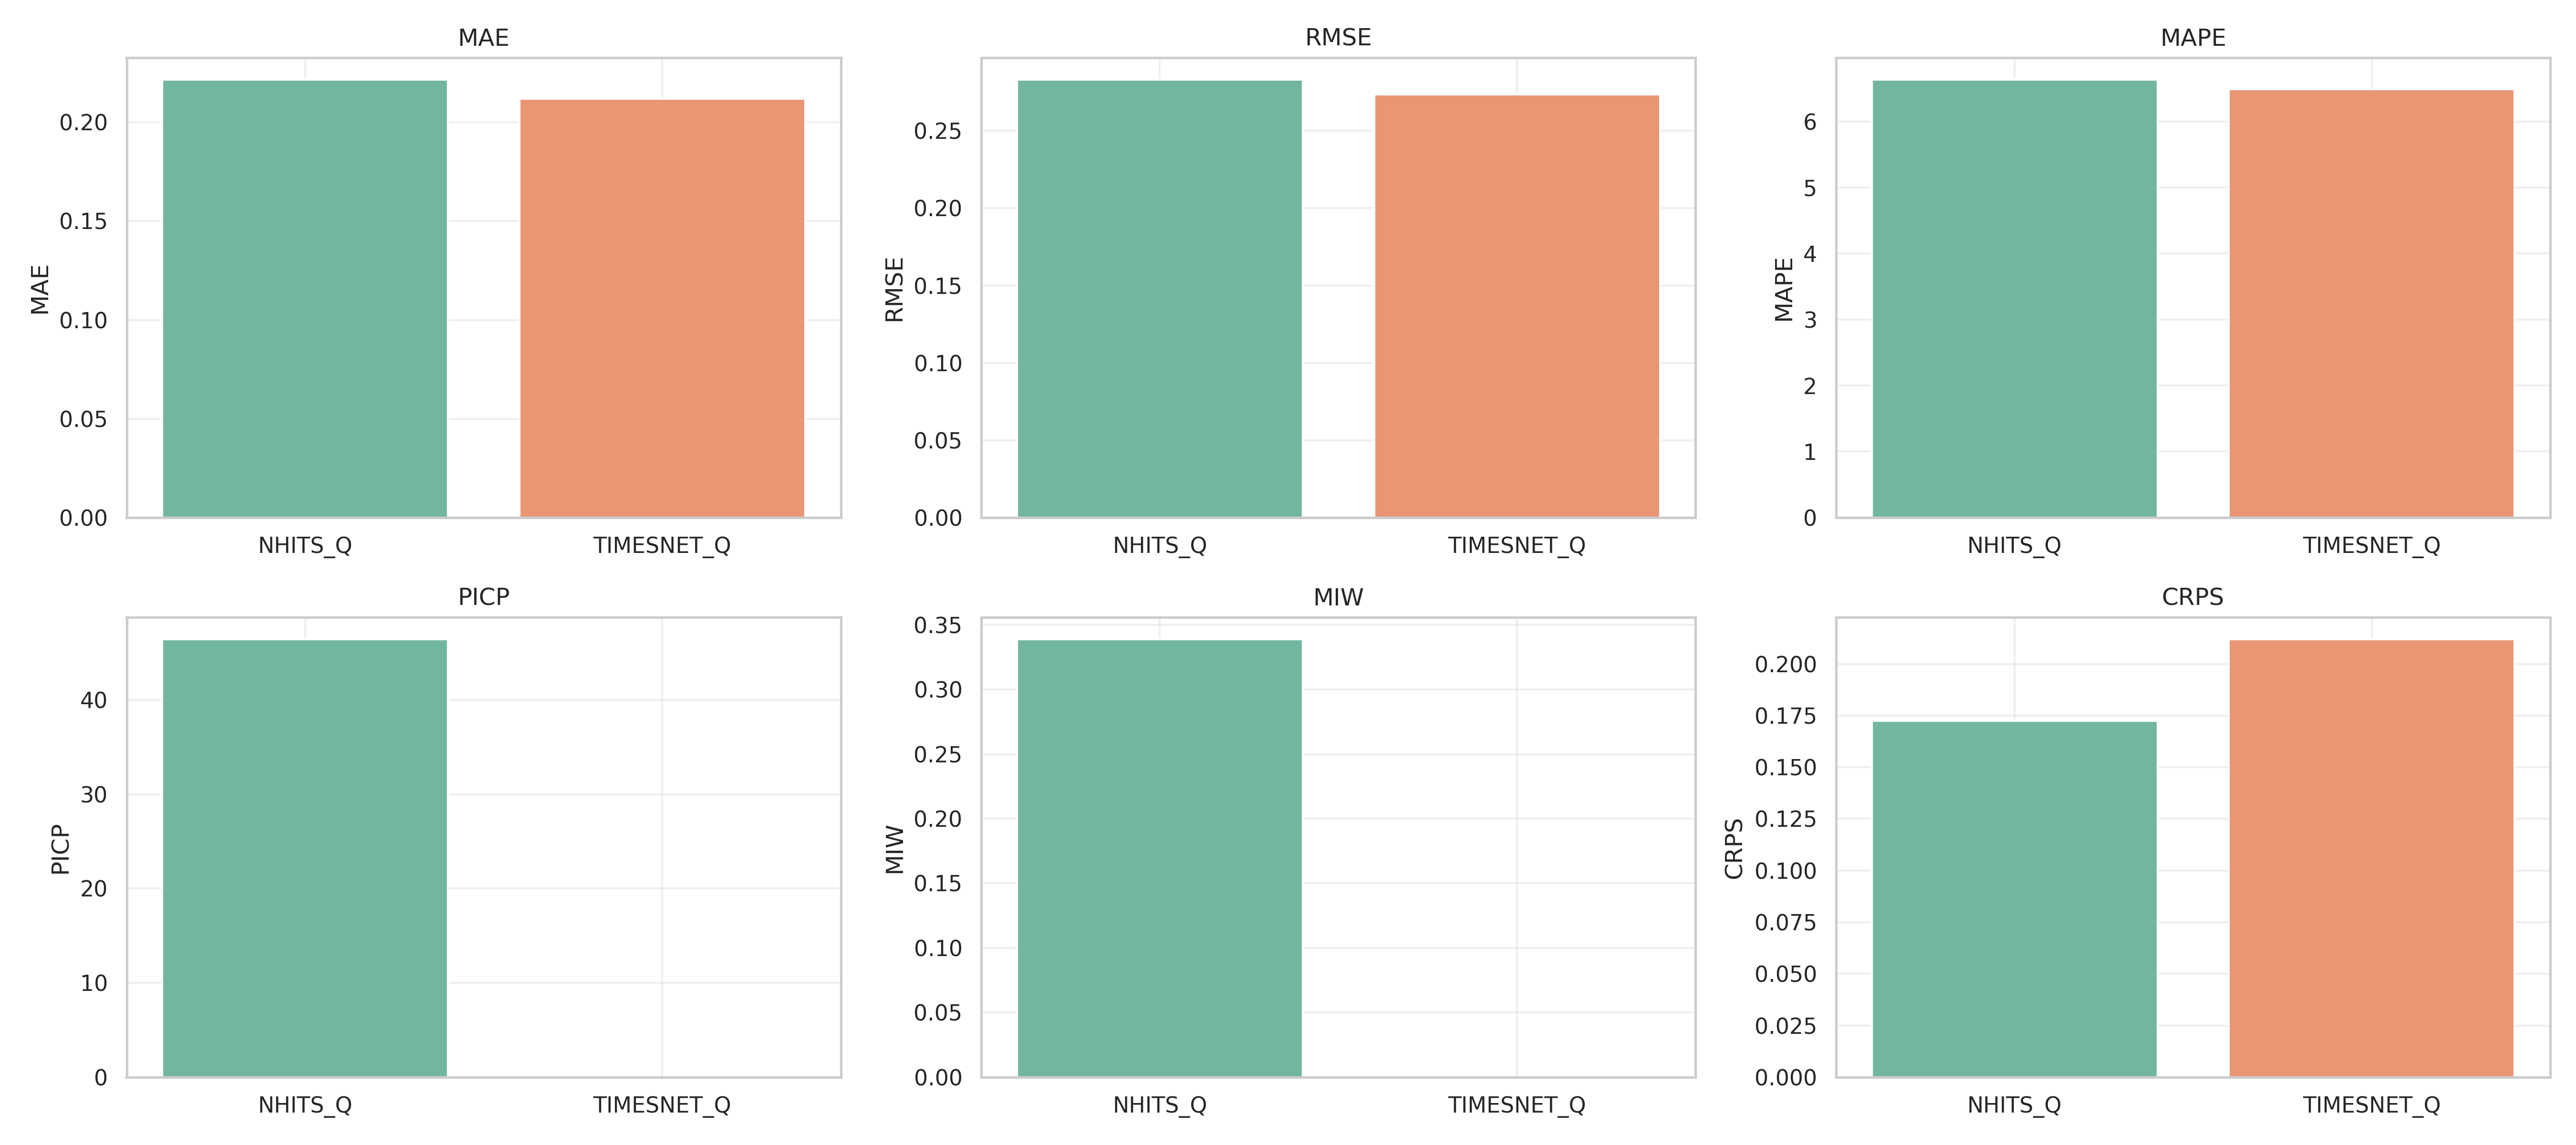

In [32]:
metrics_plot = os.path.join(RESULTS_DIR, "benchmark_metrics_barplots.png")
if os.path.exists(metrics_plot):
    display(Image(filename=metrics_plot))
else:
    print(f"Plot not found: {metrics_plot}")

### 6.2 Box Plots - Prediction Distributions

In [11]:
boxplot_img = os.path.join(RESULTS_DIR, "benchmark_boxplots.png")
if os.path.exists(boxplot_img):
    display(Image(filename=boxplot_img))
else:
    print(f"Plot not found: {boxplot_img}")

Plot not found: ../results/benchmark_boxplots.png


### 6.3 Side-by-Side Time Series Comparison

In [12]:
sidebyside_img = os.path.join(RESULTS_DIR, "benchmark_comparison_sidebyside.png")
if os.path.exists(sidebyside_img):
    display(Image(filename=sidebyside_img))
else:
    print(f"Plot not found: {sidebyside_img}")

Plot not found: ../results/benchmark_comparison_sidebyside.png


## 7. View Benchmark History

Track improvements over multiple runs.

In [13]:
# View benchmark history across all runs
history_file = os.path.join(RESULTS_DIR, "benchmark_history.csv")

if os.path.exists(history_file):
    history = pd.read_csv(history_file)
    
    print("📊 HEAT BENCHMARK HISTORY - ALL RUNS")
    print("="*70)
    print(f"Total runs recorded: {len(history)}")
    print(f"Models tracked: {', '.join(history['Model'].unique())}")
    print("\n" + "="*70)
    
    # Show all runs with key metrics
    display_cols = ['run_date', 'Model', 'n_epochs', 'has_hpo', 'MAE', 'RMSE', 'MAPE', 'CRPS']
    available_cols = [col for col in display_cols if col in history.columns]
    display(history[available_cols].sort_values('run_date', ascending=False))
    
    # Show best results ever
    print("\n🏆 BEST RESULTS EVER ACHIEVED")
    print("="*70)
    for model in history['Model'].unique():
        model_history = history[history['Model'] == model]
        print(f"\n{model}:")
        for metric in ['MAE', 'RMSE', 'MAPE', 'CRPS']:
            if metric in model_history.columns:
                best_idx = model_history[metric].idxmin()
                best_val = model_history.loc[best_idx, metric]
                best_date = model_history.loc[best_idx, 'run_date']
                print(f"  {metric:8s}: {best_val:.4f} (achieved on {best_date})")
else:
    print("❌ No benchmark history found yet.")
    print(f"   Expected file: {history_file}")
    print("\n💡 Run a benchmark first to start tracking results.")

❌ No benchmark history found yet.
   Expected file: ../results/benchmark_history.csv

💡 Run a benchmark first to start tracking results.


## 8. Summary and Conclusions

### Key Findings:

Compare these results with the water benchmarking results to analyze domain differences.

**Next Steps:**
- Review individual model plots for detailed error analysis
- Compare with water benchmark results (in `water_centrum_benchmark/results/`)
- Consider hyperparameter optimization if results need improvement (see `hpo/` folder)
- Examine specific time periods where models differ significantly

## Test TimesNet Quantile End-to-End

Quick test to verify TimesNet generates proper quantile predictions with the fixed column naming.

## Quick Test TimesNet (5 epochs only)

Fast test to verify column fix works without waiting for full training.

In [ ]:
import sys
import os

# Add project root to path
PROJECT_ROOT = '/home/hpc/iwi5/iwi5389h/ExAI-Timeseries-Thesis'
if PROJECT_ROOT not in sys.path:
    sys.path.insert(0, PROJECT_ROOT)

from benchmarker import Benchmarker

# Paths for heat dataset
heat_csv = '/home/hpc/iwi5/iwi5389h/ExAI-Timeseries-Thesis/processing/nordbyen_processing/nordbyen_features_engineered.csv'
heat_results = '/home/hpc/iwi5/iwi5389h/ExAI-Timeseries-Thesis/nordbyen_heat_benchmark/results'

print("Quick Test: TimesNet with only 5 epochs...")
print("=" * 60)

benchmarker_quick = Benchmarker(
    csv_path=heat_csv,
    models_to_run=["TIMESNET_Q"],
    results_dir=heat_results,
    dataset="Heat (Nordbyen)"
)

# Override to use only 5 epochs for quick test
benchmarker_quick.configs["TIMESNET_Q"]["n_epochs"] = 5

print("⚠️  Running with 5 epochs only (for quick column verification)")
print("   Full training uses 150 epochs and takes ~2-3 hours\n")

# Run quick benchmark
results_quick = benchmarker_quick.run()

# Check results
print("\n" + "=" * 60)
print("QUICK TEST RESULTS:")
print("=" * 60)
print(results_quick)
print("\n⚠️  Metrics will be poor (only 5 epochs) - we're just checking column extraction:")
if len(results_quick) > 0:
    picp = results_quick['PICP_80'].iloc[0]
    miw = results_quick['MIW_80'].iloc[0]
    print(f"PICP_80: {picp:.4f}")
    print(f"MIW_80: {miw:.4f}")
    if picp > 0 and miw > 0:
        print("✓ SUCCESS: Column fix works! Quantiles are being extracted.")
    else:
        print("✗ FAILURE: Still has quantile collapse issue!")

In [ ]:
import sys
import os

# Add project root to path
PROJECT_ROOT = '/home/hpc/iwi5/iwi5389h/ExAI-Timeseries-Thesis'
if PROJECT_ROOT not in sys.path:
    sys.path.insert(0, PROJECT_ROOT)

from benchmarker import Benchmarker

# Paths for heat dataset (use feature-engineered data)
heat_csv = '/home/hpc/iwi5/iwi5389h/ExAI-Timeseries-Thesis/processing/nordbyen_processing/nordbyen_features_engineered.csv'
heat_results = '/home/hpc/iwi5/iwi5389h/ExAI-Timeseries-Thesis/nordbyen_heat_benchmark/results'

# Test TimesNet Quantile
print("Testing TimesNet Quantile on Nordbyen Heat Dataset...")
print("=" * 60)

benchmarker_heat = Benchmarker(
    csv_path=heat_csv,
    models_to_run=["TIMESNET_Q"],
    results_dir=heat_results,
    dataset="Heat (Nordbyen)"
)

# Run the benchmark
results_heat = benchmarker_heat.run()

# Display results
print("\n" + "=" * 60)
print("HEAT TIMESNET RESULTS:")
print("=" * 60)
print(results_heat)
print("\nChecking for quantile collapse...")
if len(results_heat) > 0:
    picp = results_heat['PICP_80'].iloc[0]
    miw = results_heat['MIW_80'].iloc[0]
    print(f"PICP_80: {picp:.4f} (should be > 0)")
    print(f"MIW_80: {miw:.4f} (should be > 0)")
    if picp > 0 and miw > 0:
        print("✓ SUCCESS: Quantiles are properly spread!")
    else:
        print("✗ FAILURE: Quantile collapse detected!")

Testing TimesNet Quantile on Nordbyen Heat Dataset...

BENCHMARKER CONFIGURATION
TIMESNET_Q: n_epochs=150, HPO Status: ✓ Using HPO best params


[TIMESNET_Q] Training...


Seed set to 1


  [OK] Loaded and validated 48574 rows from /home/hpc/iwi5/iwi5389h/ExAI-Timeseries-Thesis/processing/nordbyen_processing/nordbyen_features_engineered.csv
  [OK] Time range: 2015-05-01 23:00:00+00:00 to 2020-11-14 20:00:00+00:00
  [OK] All 24 required columns present
  Training setup: 150 epochs × 1005 steps/epoch = 150750 total steps
  Using calibrated quantiles from Stage 2: [0.1, 0.5, 0.9]
  Using optimized hyperparameters from HPO
  DEBUG best_params keys: ['stage', 'model', 'dataset', 'objective', 'target_picp', 'achieved_picp', 'calibration_error', 'calibrated_quantiles', 'architecture_params', 'timestamp', 'note']
  DEBUG arch_params keys: ['hidden_size', 'conv_hidden_size', 'top_k', 'lr', 'dropout']
  DEBUG arch_params values: {'hidden_size': 64, 'conv_hidden_size': 64, 'top_k': 5, 'lr': 0.0001, 'dropout': 0.1}
  DEBUG final model_params: hidden_size=64, top_k=5, lr=0.0001, dropout=0.1


GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name           | Type          | Params | Mode 
---------------------------------------------------------
0 | loss           | MQLoss        | 7      | train
1 | padder_train   | ConstantPad1d | 0      | train
2 | scaler         | TemporalNorm  | 0      | train
3 | model          | ModuleList    | 4.7 M  | train
4 | enc_embedding  | DataEmbedding | 1.7 K  | train
5 | layer_norm     | LayerNorm     | 128    | train
6 | predict_linear | Linear        | 32.4 K | train
7 | projection     | Linear        | 455    | train
---------------------------------------------------------
4.7 M     Trainable params
7         Non-trainable params
4.7 M     Total params
18.888    Total estimated model params size (MB)
52        Modules in train mode
0         Modules in eval mode


Epoch 27:   0%|          | 0/1 [00:00<?, ?it/s, v_num=0, train_loss_step=4.950, train_loss_epoch=4.950]            

[rank: 0] Received SIGTERM: 15


Epoch 27: 100%|██████████| 1/1 [00:20<00:00,  0.05it/s, v_num=0, train_loss_step=4.640, train_loss_epoch=4.640]

SIGTERMException: 

/home/hpc/iwi5/iwi5389h/.conda/envs/myenv/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3558: UserWarning: To exit: use 'exit', 'quit', or Ctrl-D.
  warn("To exit: use 'exit', 'quit', or Ctrl-D.", stacklevel=1)


: 